# Classificação multiclasse de imagens satelitais

[Link para o trabalho relacionado](https://www.kaggle.com/datasets/horton1314/ustssmoker/data)

## 0 Importar bibliotecas

In [1]:
import torch
from torch import nn


import warnings
warnings.filterwarnings('ignore')

torch.__version__

'2.1.2+cu121'

In [11]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
from torchinfo import summary
from pavic_treinamento_ml.going_modular.going_modular import data_setup, engine

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1 Aquisição de dados

### Varredura do dataset

In [15]:
import os

def walk_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"{len(dirnames)} pastas e {len(filenames)} imagens em [{dirpath}].")

In [13]:
import requests
import zipfile
from pathlib import Path

data_path = Path("dataset/dataset_splitted_smokers_min")
image_path = data_path

In [16]:
walk_dir(image_path)

3 pastas e 0 imagens em [dataset/dataset_splitted_smokers_min].
3 pastas e 0 imagens em [dataset/dataset_splitted_smokers_min/train].
0 pastas e 807 imagens em [dataset/dataset_splitted_smokers_min/train/Dust].
0 pastas e 812 imagens em [dataset/dataset_splitted_smokers_min/train/Smoke].
0 pastas e 931 imagens em [dataset/dataset_splitted_smokers_min/train/Cloud].
3 pastas e 0 imagens em [dataset/dataset_splitted_smokers_min/test].
0 pastas e 102 imagens em [dataset/dataset_splitted_smokers_min/test/Dust].
0 pastas e 103 imagens em [dataset/dataset_splitted_smokers_min/test/Smoke].
0 pastas e 117 imagens em [dataset/dataset_splitted_smokers_min/test/Cloud].
3 pastas e 0 imagens em [dataset/dataset_splitted_smokers_min/val].
0 pastas e 100 imagens em [dataset/dataset_splitted_smokers_min/val/Dust].
0 pastas e 101 imagens em [dataset/dataset_splitted_smokers_min/val/Smoke].
0 pastas e 116 imagens em [dataset/dataset_splitted_smokers_min/val/Cloud].


In [17]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('dataset/dataset_splitted_smokers_min/train'),
 PosixPath('dataset/dataset_splitted_smokers_min/test'))

Path:  dataset/dataset_splitted_smokers_min/train/Cloud/cloud_1141.tif
Class:  Cloud
Height:  256
Width:  256


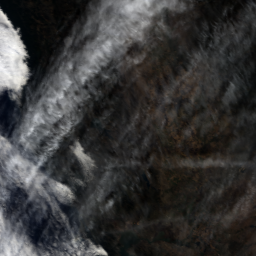

In [18]:
# Visualizar uma imagem

import random
from PIL import Image

#1 ler todos 'caminhos' das imagens
image_path_list = list(image_path.glob("*/*/*.tif"))

#2 selecionar imagem random
random_image_path = random.choice(image_path_list)

#3 selecionar classe
image_class = random_image_path.parent.stem

#4 ler img
img = Image.open(random_image_path)

print("Path: ", random_image_path)
print("Class: ", image_class)
print("Height: ", img.height)
print("Width: ", img.width)
img

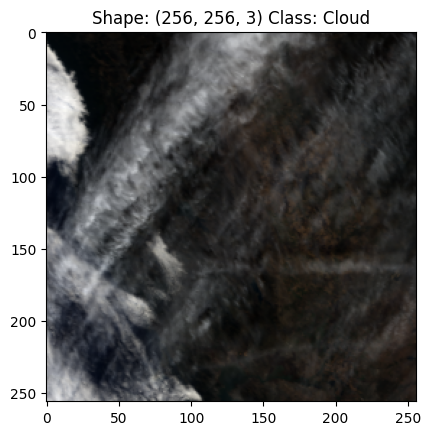

In [19]:
import numpy as np
import matplotlib.pyplot as plt

img_array = np.asarray(img)
plt.imshow(img_array);
plt.title(f"Shape: {img_array.shape} Class: {image_class}");

## 2 Load to Tensors

In [20]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [21]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [22]:
def plot_transformed_images(image_paths,
                            transform,
                            n=3):

  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \n Size:{f.size}")
      ax[0].axis("off")
      #[C, H, W]-[3, 64, 64]-[0, 1, 2]-[64, 64, 3]-[H, W , C]
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \n Size: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)



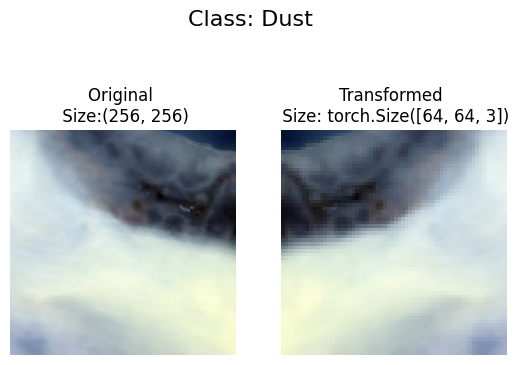

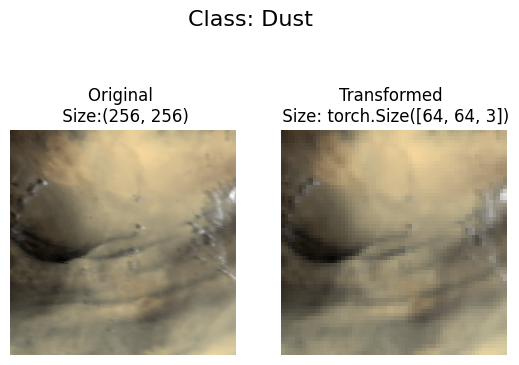

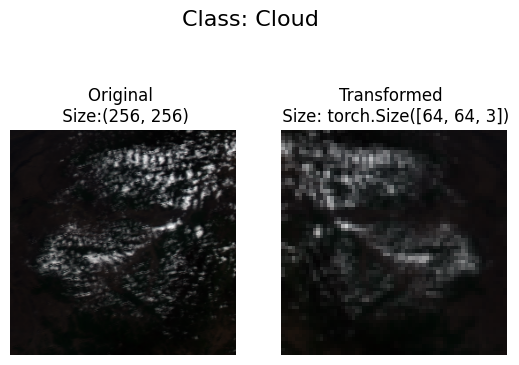

In [23]:
plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

## Opção 1: Carregar os dados com Image Folder

In [24]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform)
train_data

Dataset ImageFolder
    Number of datapoints: 2550
    Root location: dataset/dataset_splitted_smokers_min/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [25]:
#get class
class_names = train_data.classes
class_names

['Cloud', 'Dust', 'Smoke']

## 3 Carregar para o Dataloader

## Opção 2: Carregar os dados com Custom Dataset

In [26]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [27]:
#função para retornar lista de classes e dicionario de classes
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  if not classes:
    raise FileNotFoundError(f"Classes nao encontradas na pasta {directory}.")

  class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
  return classes, class_to_idx

In [28]:
find_classes(train_dir)

(['Cloud', 'Dust', 'Smoke'], {'Cloud': 0, 'Dust': 1, 'Smoke': 2})

In [83]:
class ImageFolderCustom(Dataset):
  def __init__(self, targ_dir:str, transform=None) -> None:
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.tif"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  #Função para carregar imagens
  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  #__len__ -> sobrescrever o metodo
  def __len__(self) -> int:
    return len(self.paths)

  #__getitem__
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img=self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

## 3 Preparando a Rede Neural Efficient Net

In [29]:
import torchvision

from torch import nn
from torchvision import transforms

In [30]:
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT
model = torchvision.models.efficientnet_b1(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /home/wallison/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100.0%


Define transformers manuais

In [31]:
manual_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Define transformers automático

In [87]:
#carregamento automatico do transform
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [35]:
#criar o dataloader
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=16
)

Summary

In [36]:
summary(model=model,
        input_size=(16, 3, 64, 64),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [16, 3, 64, 64]      [16, 1000]           --                   Partial
├─Sequential (features)                                      [16, 3, 64, 64]      [16, 1280, 2, 2]     --                   False
│    └─Conv2dNormActivation (0)                              [16, 3, 64, 64]      [16, 32, 32, 32]     --                   False
│    │    └─Conv2d (0)                                       [16, 3, 64, 64]      [16, 32, 32, 32]     (864)                False
│    │    └─BatchNorm2d (1)                                  [16, 32, 32, 32]     [16, 32, 32, 32]     (64)                 False
│    │    └─SiLU (2)                                         [16, 32, 32, 32]     [16, 32, 32, 32]     --                   --
│    └─Sequential (1)                                        [16, 32, 32, 32]     [16, 

### Congelar camadas

In [37]:
for param in model.features.parameters():
  param.requires_grad = False

In [47]:
output_shape = len(class_names)


model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.4, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)

In [39]:
summary(model=model,
        input_size=(1, 3, 16, 16),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 16, 16]       [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 16, 16]       [1, 1280, 1, 1]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 16, 16]       [1, 32, 8, 8]        --                   False
│    │    └─Conv2d (0)                                       [1, 3, 16, 16]       [1, 32, 8, 8]        (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 8, 8]        [1, 32, 8, 8]        (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 8, 8]        [1, 32, 8, 8]        --                   --
│    └─Sequential (1)                                        [1, 32, 8, 8]        [1, 1

In [40]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [41]:
from timeit import default_timer as timer
start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=50,
                       device=device)
end_time = timer()

print(f"Tempo de treinamento: {end_time-start_time:.3f} segundos")

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:55<45:07, 55.26s/it]

Epoch: 1 | train_loss: 0.7570 | train_acc: 0.6988 | test_loss: 0.5933 | test_acc: 0.8006


  4%|▍         | 2/50 [01:15<27:40, 34.59s/it]

Epoch: 2 | train_loss: 0.5874 | train_acc: 0.7694 | test_loss: 0.5345 | test_acc: 0.8125


  6%|▌         | 3/50 [01:37<22:42, 28.98s/it]

Epoch: 3 | train_loss: 0.5592 | train_acc: 0.7858 | test_loss: 0.5594 | test_acc: 0.8185


  8%|▊         | 4/50 [02:00<20:16, 26.45s/it]

Epoch: 4 | train_loss: 0.5169 | train_acc: 0.8018 | test_loss: 0.5135 | test_acc: 0.8333


 10%|█         | 5/50 [02:20<18:09, 24.21s/it]

Epoch: 5 | train_loss: 0.5083 | train_acc: 0.8026 | test_loss: 0.5030 | test_acc: 0.8274


 12%|█▏        | 6/50 [02:41<16:53, 23.04s/it]

Epoch: 6 | train_loss: 0.4911 | train_acc: 0.8064 | test_loss: 0.4592 | test_acc: 0.8274


 14%|█▍        | 7/50 [03:01<15:55, 22.23s/it]

Epoch: 7 | train_loss: 0.4868 | train_acc: 0.8158 | test_loss: 0.4757 | test_acc: 0.8214


 16%|█▌        | 8/50 [03:21<15:03, 21.51s/it]

Epoch: 8 | train_loss: 0.4703 | train_acc: 0.8132 | test_loss: 0.5024 | test_acc: 0.8244


 18%|█▊        | 9/50 [03:41<14:22, 21.04s/it]

Epoch: 9 | train_loss: 0.4738 | train_acc: 0.8185 | test_loss: 0.4888 | test_acc: 0.8125


 20%|██        | 10/50 [04:01<13:48, 20.72s/it]

Epoch: 10 | train_loss: 0.4931 | train_acc: 0.8122 | test_loss: 0.6168 | test_acc: 0.8274


 22%|██▏       | 11/50 [04:23<13:38, 20.99s/it]

Epoch: 11 | train_loss: 0.4631 | train_acc: 0.8190 | test_loss: 0.4699 | test_acc: 0.8304


 24%|██▍       | 12/50 [04:42<12:52, 20.33s/it]

Epoch: 12 | train_loss: 0.4728 | train_acc: 0.8146 | test_loss: 0.4727 | test_acc: 0.8333


 26%|██▌       | 13/50 [04:59<11:55, 19.35s/it]

Epoch: 13 | train_loss: 0.4642 | train_acc: 0.8187 | test_loss: 0.4634 | test_acc: 0.8423


 28%|██▊       | 14/50 [05:16<11:15, 18.77s/it]

Epoch: 14 | train_loss: 0.4672 | train_acc: 0.8243 | test_loss: 0.4573 | test_acc: 0.8333


 30%|███       | 15/50 [05:34<10:44, 18.42s/it]

Epoch: 15 | train_loss: 0.4727 | train_acc: 0.8171 | test_loss: 0.4252 | test_acc: 0.8274


 32%|███▏      | 16/50 [05:52<10:21, 18.27s/it]

Epoch: 16 | train_loss: 0.4904 | train_acc: 0.8173 | test_loss: 0.4239 | test_acc: 0.8304


 34%|███▍      | 17/50 [06:10<10:07, 18.40s/it]

Epoch: 17 | train_loss: 0.4780 | train_acc: 0.8186 | test_loss: 0.4882 | test_acc: 0.8214


 36%|███▌      | 18/50 [06:28<09:43, 18.25s/it]

Epoch: 18 | train_loss: 0.4648 | train_acc: 0.8176 | test_loss: 0.4823 | test_acc: 0.8155


 38%|███▊      | 19/50 [06:48<09:38, 18.67s/it]

Epoch: 19 | train_loss: 0.4683 | train_acc: 0.8174 | test_loss: 0.4176 | test_acc: 0.8333


 40%|████      | 20/50 [07:05<09:05, 18.17s/it]

Epoch: 20 | train_loss: 0.4516 | train_acc: 0.8233 | test_loss: 0.4426 | test_acc: 0.8423


 42%|████▏     | 21/50 [07:22<08:37, 17.83s/it]

Epoch: 21 | train_loss: 0.4535 | train_acc: 0.8198 | test_loss: 0.5452 | test_acc: 0.8214


 44%|████▍     | 22/50 [07:40<08:21, 17.90s/it]

Epoch: 22 | train_loss: 0.4570 | train_acc: 0.8212 | test_loss: 0.4090 | test_acc: 0.8423


 46%|████▌     | 23/50 [07:56<07:50, 17.44s/it]

Epoch: 23 | train_loss: 0.4655 | train_acc: 0.8199 | test_loss: 0.6694 | test_acc: 0.8274


 48%|████▊     | 24/50 [08:14<07:30, 17.33s/it]

Epoch: 24 | train_loss: 0.4640 | train_acc: 0.8173 | test_loss: 0.4468 | test_acc: 0.8125


 50%|█████     | 25/50 [08:32<07:20, 17.61s/it]

Epoch: 25 | train_loss: 0.4453 | train_acc: 0.8270 | test_loss: 0.4583 | test_acc: 0.8065


 52%|█████▏    | 26/50 [08:50<07:07, 17.83s/it]

Epoch: 26 | train_loss: 0.4567 | train_acc: 0.8203 | test_loss: 0.4373 | test_acc: 0.8274


 54%|█████▍    | 27/50 [09:09<06:53, 17.99s/it]

Epoch: 27 | train_loss: 0.4596 | train_acc: 0.8216 | test_loss: 0.4542 | test_acc: 0.8423


 56%|█████▌    | 28/50 [09:30<06:55, 18.91s/it]

Epoch: 28 | train_loss: 0.4528 | train_acc: 0.8293 | test_loss: 0.4977 | test_acc: 0.8363


 58%|█████▊    | 29/50 [09:52<06:56, 19.82s/it]

Epoch: 29 | train_loss: 0.4789 | train_acc: 0.8079 | test_loss: 0.4988 | test_acc: 0.8095


 60%|██████    | 30/50 [10:15<06:59, 20.97s/it]

Epoch: 30 | train_loss: 0.4852 | train_acc: 0.8189 | test_loss: 0.4620 | test_acc: 0.8155


 62%|██████▏   | 31/50 [10:38<06:51, 21.66s/it]

Epoch: 31 | train_loss: 0.4997 | train_acc: 0.7947 | test_loss: 0.4787 | test_acc: 0.8185


 64%|██████▍   | 32/50 [11:01<06:32, 21.83s/it]

Epoch: 32 | train_loss: 0.4662 | train_acc: 0.8245 | test_loss: 0.5121 | test_acc: 0.8185


 66%|██████▌   | 33/50 [11:21<06:05, 21.49s/it]

Epoch: 33 | train_loss: 0.4794 | train_acc: 0.8060 | test_loss: 0.4580 | test_acc: 0.8363


 68%|██████▊   | 34/50 [11:41<05:36, 21.04s/it]

Epoch: 34 | train_loss: 0.4735 | train_acc: 0.8163 | test_loss: 0.4525 | test_acc: 0.8155


 70%|███████   | 35/50 [12:00<05:04, 20.27s/it]

Epoch: 35 | train_loss: 0.4284 | train_acc: 0.8302 | test_loss: 0.4858 | test_acc: 0.7887


 72%|███████▏  | 36/50 [12:17<04:32, 19.43s/it]

Epoch: 36 | train_loss: 0.4761 | train_acc: 0.8102 | test_loss: 0.5158 | test_acc: 0.8214


 74%|███████▍  | 37/50 [12:40<04:23, 20.26s/it]

Epoch: 37 | train_loss: 0.4771 | train_acc: 0.8142 | test_loss: 0.5740 | test_acc: 0.8065


 76%|███████▌  | 38/50 [13:01<04:05, 20.48s/it]

Epoch: 38 | train_loss: 0.4499 | train_acc: 0.8290 | test_loss: 0.4470 | test_acc: 0.8274


 78%|███████▊  | 39/50 [13:21<03:44, 20.37s/it]

Epoch: 39 | train_loss: 0.4361 | train_acc: 0.8336 | test_loss: 0.4282 | test_acc: 0.8452


 80%|████████  | 40/50 [13:41<03:23, 20.33s/it]

Epoch: 40 | train_loss: 0.4415 | train_acc: 0.8313 | test_loss: 0.4423 | test_acc: 0.8185


 82%|████████▏ | 41/50 [14:01<03:02, 20.23s/it]

Epoch: 41 | train_loss: 0.4919 | train_acc: 0.8098 | test_loss: 0.4720 | test_acc: 0.8095


 84%|████████▍ | 42/50 [14:22<02:44, 20.61s/it]

Epoch: 42 | train_loss: 0.4664 | train_acc: 0.8212 | test_loss: 0.4735 | test_acc: 0.8214


 86%|████████▌ | 43/50 [14:43<02:23, 20.55s/it]

Epoch: 43 | train_loss: 0.4691 | train_acc: 0.8079 | test_loss: 0.5178 | test_acc: 0.7887


 88%|████████▊ | 44/50 [15:03<02:03, 20.51s/it]

Epoch: 44 | train_loss: 0.4608 | train_acc: 0.8193 | test_loss: 0.5258 | test_acc: 0.8304


 90%|█████████ | 45/50 [15:23<01:41, 20.27s/it]

Epoch: 45 | train_loss: 0.4600 | train_acc: 0.8171 | test_loss: 0.4405 | test_acc: 0.8065


 92%|█████████▏| 46/50 [15:43<01:20, 20.17s/it]

Epoch: 46 | train_loss: 0.5126 | train_acc: 0.7951 | test_loss: 0.4804 | test_acc: 0.8095


 94%|█████████▍| 47/50 [16:03<01:00, 20.13s/it]

Epoch: 47 | train_loss: 0.4876 | train_acc: 0.8111 | test_loss: 0.4745 | test_acc: 0.8214


 96%|█████████▌| 48/50 [16:23<00:40, 20.06s/it]

Epoch: 48 | train_loss: 0.4730 | train_acc: 0.8104 | test_loss: 0.4475 | test_acc: 0.8423


 98%|█████████▊| 49/50 [16:43<00:20, 20.19s/it]

Epoch: 49 | train_loss: 0.5012 | train_acc: 0.8036 | test_loss: 0.5289 | test_acc: 0.8006


100%|██████████| 50/50 [17:03<00:00, 20.48s/it]

Epoch: 50 | train_loss: 0.4536 | train_acc: 0.8257 | test_loss: 0.4652 | test_acc: 0.8214
Tempo de treinamento: 1024.069 segundos


In [43]:
results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

### 5.1 Plot train info

In [45]:
def plot_loss_curves(results: Dict[str, List[float]]):
  loss = results["train_loss"]
  test_loss = results["test_loss"]
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]
  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(15,7))
  #plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()
  #plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_acc")
  plt.plot(epochs, test_accuracy, label="test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

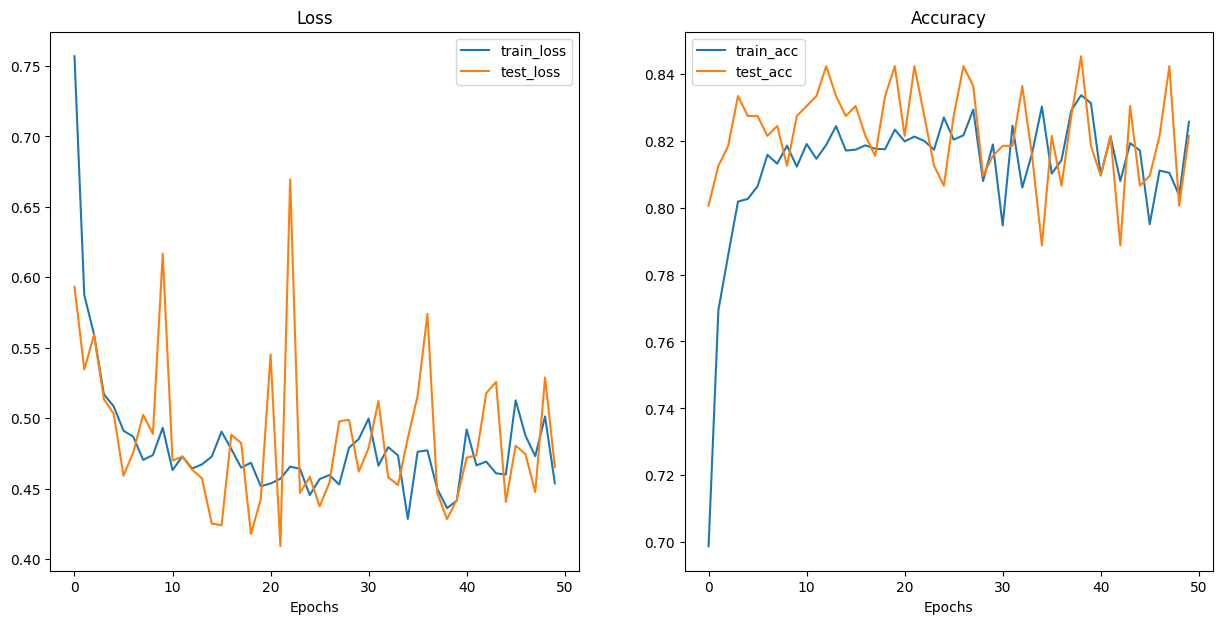

In [46]:
plot_loss_curves(results)

## 6 Testando o modelo ocm imagem da internet


In [ ]:
import torchvision

custom_image_uint8 = torchvision.io.read_image(str("pizza.jpg"))

custom_image_uint8

In [ ]:
model_0.eval()
with torch.inference_mode():
  model_0(custom_image_uint8.to(device))

RuntimeError: ignored

In [ ]:
custom_image = torchvision.io.read_image(str("pizza.jpg")).type(torch.float32)
custom_image = custom_image / 255.
custom_image.dtype, custom_image

(torch.float32,
 tensor([[[0.6431, 0.6314, 0.6863,  ..., 0.5490, 0.5176, 0.4902],
          [0.6196, 0.6235, 0.6902,  ..., 0.6039, 0.5765, 0.5490],
          [0.6392, 0.6431, 0.7020,  ..., 0.5686, 0.5412, 0.5137],
          ...,
          [0.5843, 0.6000, 0.5686,  ..., 0.6000, 0.5843, 0.6078],
          [0.6627, 0.6706, 0.6157,  ..., 0.5412, 0.5059, 0.5961],
          [0.6471, 0.6902, 0.6706,  ..., 0.6784, 0.5255, 0.5569]],
 
         [[0.6667, 0.6549, 0.7098,  ..., 0.6000, 0.5765, 0.5490],
          [0.6431, 0.6471, 0.7137,  ..., 0.6549, 0.6353, 0.6078],
          [0.6706, 0.6745, 0.7333,  ..., 0.6196, 0.6000, 0.5686],
          ...,
          [0.5961, 0.6118, 0.5922,  ..., 0.3647, 0.3451, 0.3686],
          [0.6745, 0.6824, 0.6392,  ..., 0.2980, 0.2667, 0.3569],
          [0.6588, 0.7020, 0.6941,  ..., 0.4353, 0.2863, 0.3176]],
 
         [[0.7216, 0.7098, 0.7647,  ..., 0.6314, 0.5961, 0.5686],
          [0.6980, 0.7020, 0.7686,  ..., 0.6863, 0.6549, 0.6353],
          [0.7216, 0.725

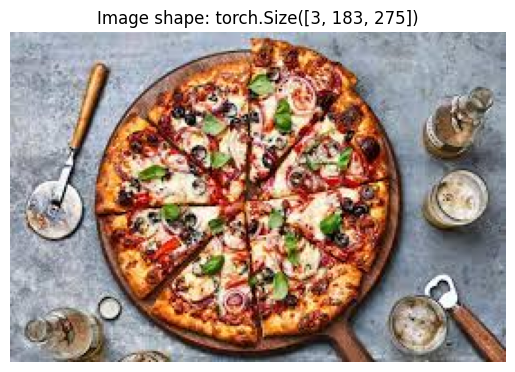

In [ ]:
plt.imshow(custom_image.permute(1, 2, 0));
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [ ]:
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64))
])
custom_image_transformed = custom_image_transform(custom_image)

custom_image_transformed.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 64, 64])

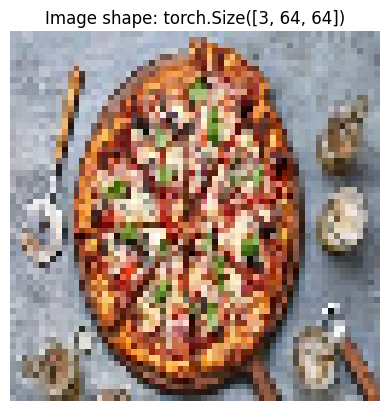

In [ ]:
plt.imshow(custom_image_transformed.permute(1, 2, 0));
plt.title(f"Image shape: {custom_image_transformed.shape}")
plt.axis(False);

In [ ]:
model_0.eval()
with torch.inference_mode():
  custom_image_pred = model_0(custom_image_transformed)

custom_image_pred

RuntimeError: ignored

In [ ]:
model_0.eval()
with torch.inference_mode():
  custom_image_pred = model_0(custom_image_transformed.to(device))

custom_image_pred

RuntimeError: ignored

In [ ]:
#[B, C, H, W]
custom_image_transformed.shape

torch.Size([3, 64, 64])

In [ ]:
model_0.eval()
with torch.inference_mode():
  custom_image_transformed = custom_image_transformed.unsqueeze(dim=0)
  print(f"Novo shape: {custom_image_transformed.shape}")
  custom_image_pred = model_0(custom_image_transformed.to(device))

Novo shape: torch.Size([1, 3, 64, 64])


In [ ]:
custom_image_pred

tensor([[ 0.6816, -2.4963, -0.5215]], device='cuda:0')

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):

  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
  target_image = target_image / 255.

  if transform:
    target_image = transform(target_image)
  model.to(device)

  model.eval()
  with torch.inference_mode():
    target_image = target_image.unsqueeze(dim=0)
    target_image_pred = model(target_image.to(device))

  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  plt.imshow(target_image.squeeze().permute(1, 2, 0))
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f} "

  plt.title(title)
  plt.axis(False);

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


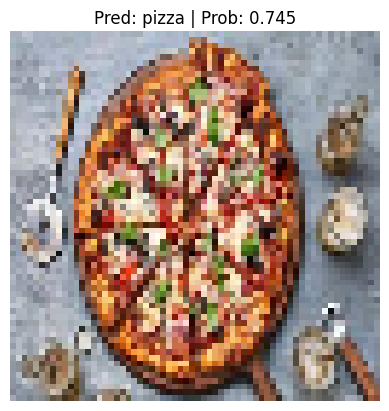

In [ ]:
pred_and_plot_image(model=model_0,
                    image_path="pizza.jpg",
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)